![Title](Images/cisco.png)

# Lab - Smile Detection 


### Objectives

The objective of this lab is to use machine learning to detect whether a person is smiling when given a picture or a video.

* <b>Part 1: Detect Faces
* Part 2: Data Processing: Face Standardization
* Part 3: Load a Pre-trained Moel
* Part 4: Real-time Smile Detection</b>

### Scenario/Background

In this lab, you will get to work on a complete image processing pipeline. You will use a machine learning model both to detect a face inside of an image and to understand whether the detected face is smiling. You will then build a real-time smile detector, that will be used to take pictures when a person is smiling.

### Required Resources
* 1 PC with Internet access
* Raspberry Pi version 2 or higher
* Camera V2 module
* Python libraries: picamera, cv2, time, matplotlib, IPython, numpy, scipy, sklearn
* Datafiles: smile.jpg, nosmile.jpg

The Raspberry Pi camera module was connected and installed in a previous lab. This lab assumes that the installation and testing of the camera module have previously been completed.

## Part 1: Detect Faces

There are two steps that involve machine learning:
* Supervised learning to detect a face
* Model evaluation to d etermine if the face is smiling

Training a model means teaching a machine how to perform a task, but rather than explicitly programming it with a predefined series of steps, the machine will have access to a dataset and will adapt its parameters to match the information provided in the training set. 

##### Supervised learning

The scenario presented in this lab belongs to the supervised learning set up. In supervised learning, the computer has access to a training set, such as a collection of pictures with faces. Each of these faces is a data point associated with a label, such as "smiling" or "not smiling".

This lab is presented with a binary classification task. There are two classes: one containing all the pictures where there is a smiling face and the other group containing a face that is not smiling. The goal of the model is to assign a data point to one of the two classes: smiling and not smiling.

How does the computer know how to classify a data point? The computer will observe the relationship between training points and labels, and will try to infer the rules that connect the two, so that when a new, unseen data point arrives, it will be possible to classify it following the same rules.

In traditional programming, a computer was given an algorithm, a dataset, and it produced an output:

![Title](Images/traditional.png)

In supervised machine learning, a computer is given input data and output data, and it produces an algorithm. 

![Title](Images/ML.png)

The quality of the algorithm depends on the quality of the given input. It is crucial that the input data is a good representation of the model being considered.

In this lab, a pre-trained model is provided for face detection and smile recognition. This pre-trained model has already learned the relationship between input faces and output labels. 

This is a sample of the faces used to train the model:

![title](Images/olivetti_sample.png)

They come from one of the datasets that can be found in sklearn (see http://scikit-learn.org/stable/datasets/olivetti_faces.html). The Olivetti Faces dataset is typically used for identity recognition. This dataset has ten different images of each of the 40 distinct subjects. In this lab, the original target variables were replaced with binary labels, a similing face or a not similing face.

##### Model evaluation

The dataset has been divided into a training and a test set. 75% of the data is in the training set and 25% is in the test set. It is good practice to do this to evaluate the model performance, and to avoid having a super complicated model that fits the training data perfectly but does not generalize, known as overfitting.

The first task, given an image, will be to identify the face(s) inside of it: to do so, you will use the OpenCV pipeline for face detection. With the same library, it is possible to build real time applications for mobile phones, for example.

To understand whether the detected face is smiling or not, some pre-processing is needed. The picture will have to be transformed to be compatible with the data accepted by the model. In this case, each face will have to be of dimension 64x64 pixels, and be greyscale.

An offline pipeline is implemented to see how the model works on two test images. Then, the same steps will be embedded in an online pipeline, so that the smile detector will work in real time, acquiring the images from the camera.

### Step 1: Import libraries.

###   OpenCV  <img src="Images/opencv_logo.png" align="left" width="20">   

OpenCV (Open Source Computer Vision Library) is an open source computer vision and machine learning software library. OpenCV was built to provide a common infrastructure for computer vision applications and to accelerate the use of machine perception in commercial products. It has C++, C, Python and Java interfaces, and supports Windows, Linux, Mac OS, iOS, and Android.

The library has more than 2500 optimized algorithms, which includes a comprehensive set of both classic and state-of-the-art computer vision and machine learning algorithms, such as facial detection and recognition. The library is used extensively in companies, research groups, and by governmental bodies. [source](http://opencv.org/about.html)

### OpenCV-Python

Compared to other languages like C/C++, Python is slower. But another important feature of Python is that it can be easily extended with C/C++. This feature helps us to write computationally intensive codes in C/C++ and create a Python wrapper for it so that we can use these wrappers as Python modules. This gives us two advantages: first, our code is as fast as original C/C++ code because it is the actual C++ code working in background, and second, it is very easy to code in Python. This is how OpenCV-Python works, it is a Python wrapper around original C++ implementation. [source](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_setup/py_intro/py_intro.html#intro)

You will import the module `cv2`, the Python version of `OpenCV`, and other libraries for loading and viewing the image data.

For more information about reading and writing images and video, click [here](http://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html).

In [1]:
# Code Cell 1
# Importing cv2
import cv2

from IPython.display import display, clear_output

from matplotlib import pyplot as plt

%matplotlib inline

### Step 2: Read and view test data.

The two provided test images are `smile.jpg` and `nosmile.jpg`. It is possible to read and store them in variables through the function `cv2.imread()`.

a) Load the two test images

In [2]:
# Code Cell 2
smile = cv2.imread('Images/smile.jpg')
no_smile = cv2.imread('Images/nosmile.jpg')

b) Visualize the two test images.

Text(0.5, 1.0, 'No smile')

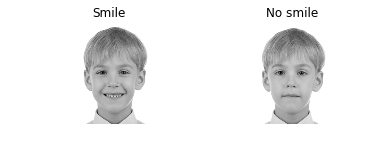

In [3]:
# Code Cell 3
# visualize the two test images
fig, ax = plt.subplots(1, 2)
clear_output()
ax[0].imshow(cv2.cvtColor(smile, cv2.COLOR_BGR2GRAY), cmap='gray')
ax[0].axis('off')
ax[0].set_title('Smile')
ax[1].imshow(cv2.cvtColor(no_smile, cv2.COLOR_BGR2GRAY), cmap='gray')
ax[1].axis('off')
ax[1].set_title('No smile')

### Step 3: Face detection

The provided model accepts faces as input, so it is necessary to find the face(s) inside the images. OpenCV provides a pipeline to detect faces using a cascade classifier trained on haar-like features. 

Haar-like features are filters that highlight different structures inside of an image. For instance, they will spot edges, lines, corners etc. A cascade classifier is a sequence of classifiers that operate with features at different levels. The idea is that each image is decomposed with respect to these features. The model already knows which of these features are included in a face image. When the relevant group of features is spotted by the model, a face is returned. 

In practice, the face detection pipeline works as follows:

a) Select the file containing the haar features needed to detect faces inside an image and initialize a cascade classifier in OpenCV.

In [4]:
# Code Cell 4
# path to the file containing the features that the openCv pipeline will look for in the frame
cascadePath = "Data/haarcascade_frontalface_default.xml"
# initialize a model for detecting whether a certain portion of an image contains a face
faceCascade = cv2.CascadeClassifier(cascadePath)

b) Convert the frame to grayscale.

In [5]:
# Code Cell 5
gray_smile = cv2.cvtColor(smile, cv2.COLOR_BGR2GRAY)

c) Use the OpenCv classifier to detect the faces inside the image.

In [ ]:
# Code Cell 6
# openCv algorithm to scan the image looking for haar features
faces = faceCascade.detectMultiScale(
        gray_smile,
        scaleFactor=1.1,
        minNeighbors=6,
        minSize=(100, 100),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
# output of the classifier
faces

d) Visualize the outcome of the algorithm by drawing a green rectangle around the face detected by the algorithm.

(-0.5, 1079.5, 719.5, -0.5)

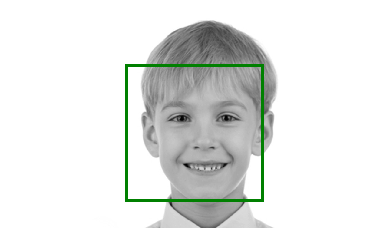

In [9]:
# Code Cell 7
# draw a rectangle
from matplotlib.patches import Rectangle

# visualize the detected face
fig, ax = plt.subplots()
ax.imshow(gray_smile, cmap='gray')

# iterate over all the detected faces
for face in faces:
    # retrieve the coordinates of the position of the current face, and its size    
    (x_smile, y_smile, w_smile, h_smile) = face
    # draw a rectangle where the face is detected    
    ax.add_artist(Rectangle((x_smile, y_smile), w_smile, h_smile, fill=False, lw=3, color='green'))

ax.axis('off')

e) Repeat on the other test image to detect the face using OpenCV classifier and convert the image to grayscale.

In [10]:
# Code Cell 8
# convert the image to grayscale
gray_nosmile = cv2.cvtColor(no_smile, cv2.COLOR_BGR2GRAY)

# openCv algorithm to scan the image looking for haar features
faces = faceCascade.detectMultiScale(
        gray_nosmile,
        scaleFactor=1.1,
        minNeighbors=6,
        minSize=(100, 100),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

# output of the classifier
faces

array([[306, 179, 450, 450]], dtype=int32)

f) Visualize the outcome of the algorithm by drawing a red rectangle around the face detected by the algorithm.

(-0.5, 1079.5, 719.5, -0.5)

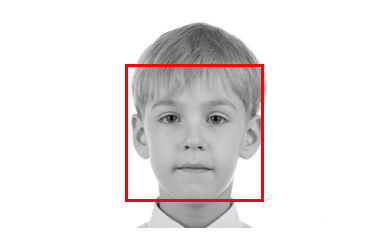

In [11]:
# Code Cell 9
# visualize the detected face
fig, ax = plt.subplots()
ax.imshow(gray_nosmile, cmap='gray')

# iterate over all the detected faces
for face in faces:
    # retrieve the coordinates of the position of the current face, and its size
    (x_nosmile, y_nosmile, w_nosmile, h_nosmile) = face
    
    # draw a rectangle where the face is detected
    ax.add_artist(Rectangle((x_nosmile, y_nosmile), w_nosmile, h_nosmile, fill=False, lw=3, color='red'))
    
ax.axis('off')

## Part 2: Data Processing: Face Standardization

In the previous part, you determined the location and the size of the face. 
It is necessary to extract it from the image and transform it to the correct format expected by the model. This part of the pipeline is data pre-processing, and it is usually crucial to get good performances.

Note that the dimensions used to extract the face are not exactly the same of the detected face, but there are two coefficients to stretch the image. This is because it helps in making the faces more similar to the ones composing the training set over which the model was trained, to make the classification task easier or even possible. 

This is a sample of the faces used to train the model:

![title](Images/olivetti_sample.png)

The model will work well if the faces are similar to the ones used for training, up to a certain degree, in terms of position of the different facial features. 

This is a task that is very specific for this case, however it is important to think about how similar to the training data the new data points are.

a) Select the portion that will be used to classify whether the face is smiling.

In [12]:
# Code Cell 10
# select only the face portion from the smile test image
face_smile = gray_smile[y_smile:y_smile+h_smile, x_smile:x_smile+w_smile]

# The cropping coefficient for determining the size of the face
c1 = 0.2

# calculate how to crop the face
# vertical dimension
v_cut = int(c1 * w_smile)
# horizontal dimension
h_cut = int(c1 * h_smile)

# select only the face portion from the smile test image
cut_face_smile = gray_smile[y_smile+v_cut:y_smile+h_smile, 
                      x_smile+h_cut:x_smile-h_cut+w_smile]

b) Repeat for the other test image.

In [15]:
# Code Cell 11
# select only the face portion from the non-smile test image
face_nosmile = gray_nosmile[y_nosmile:y_nosmile+h_nosmile, x_nosmile:x_nosmile+w_nosmile]

# The cropping coefficient for determining the size of the face
c2 = 0.2

# calculate how to crop the face 
# vertical dimension
v_cut = int(c2 * w_nosmile)
# horizontal dimension
h_cut = int(c2 * h_nosmile)

# select only the face portion from the non smile test image
cut_face_nosmile = gray_nosmile[y_nosmile+v_cut:y_nosmile+h_nosmile, 
                      x_nosmile+h_cut:x_nosmile-h_cut+w_nosmile]


c) Visualize the original detected faces and the distorted ones, for comparison.

(-0.5, 269.5, 359.5, -0.5)

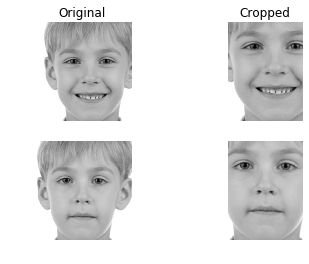

In [16]:
# Code Cell 12
fig, ax = plt.subplots(2, 2)
ax[0][0].imshow(face_smile, cmap='gray')
ax[0][0].axis('off')
ax[0][0].set_title('Original')

ax[0][1].imshow(cut_face_smile, cmap='gray')
ax[0][1].axis('off')
ax[0][1].set_title('Cropped')

ax[1][0].imshow(face_nosmile, cmap='gray')
ax[1][0].axis('off')
ax[1][1].imshow(cut_face_nosmile, cmap='gray')
ax[1][1].axis('off')

How would the two coefficients (cv and ch) affect the detected faces?

<font color = 'gray'>*Type your answer here.*</font><br>
The two coefficients determine the scale of the image and the larger value the narrower the scale gets.

d) A modification is needed, so that the data points are compatible with the pre-trained model The faces must be 64x64 pixels. This means that the aspect ratio will change. It is possible to achieve this result using the method `zoom()` from `scipy.ndimage` (see http://scipy.github.io/devdocs/generated/scipy.ndimage.zoom.html#scipy.ndimage.zoom).

Modify the dimensions of the data points.

In [17]:
# Code Cell 13
# import the numpy and scipy libraries to zoom the images
import numpy as np
from scipy.ndimage import zoom

# transform the stretched smiling face so that it has 64x64 pixels
standardized_face_smile = zoom(cut_face_smile, (64. / cut_face_smile.shape[0], 
                                           64. / cut_face_smile.shape[1])).astype(np.float32)

e) The numeric values on which the model is trained range from 0 to 1. It is possible to achieve this normalizing the data, dividing by 255, the maximum value a pixel can take.

Normalize the zoomed face by dividing by the maximum value. 

In [18]:
# Code Cell 14
# normalize the image so that its values are between 0 and 1
standardized_face_smile /= float(255)

f) Now repeat for the other test image.

In [27]:
# Code Cell 15
# transform the stretched non smiling face so that it has 64x64 pixels
standardized_face_nosmile = zoom(cut_face_nosmile, (64. / cut_face_nosmile.shape[0], 
                                           64. / cut_face_nosmile.shape[1])).astype(np.float32)

# normalize the image so that its values are between 0 and 1
standardized_face_nosmile /= float(255)


g) Visualize the two standardized faces.

(-0.5, 63.5, 63.5, -0.5)

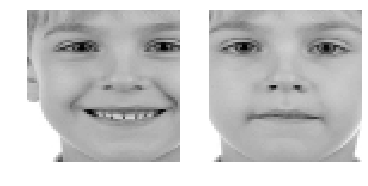

In [28]:
# Code Cell 16
plt.subplot(121)
plt.imshow(standardized_face_smile[:, :], cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(standardized_face_nosmile[:, :], cmap='gray')
plt.axis('off')

As you can see, the two faces are slightly stretched. This makes them more similar to the original training images:

![Title](Images/olivetti_big.png)

The test faces are now in the right format to be processed by the pre-trained module.

## Part 3: Loading a Pre-trained Model

Now the data is in the correct format. It is possible to load the pre-trained model, that is contained in a `pickle` file. `Pickle` is the file format to save serialized Python objects (a machine learning module in this case). To know more, see https://docs.python.org/2/library/pickle.html.

The model was trained with a Support Vector Machine (SVM), a supervised classification algorithm that looks for the optimal decision boundary to separate the different classes.
The model that implements the SVM method is `sklearn`. 

`sklearn` is one of the most used Python libraries for machine learning. It implements a wide number of methods, and offers functionalities for pre-processing, cross validation, etc. You can have a look at documentation, tutorials, and more here: http://scikit-learn.org/stable/documentation.html.

To learn more about SVMs in sklearn, see http://scikit-learn.org/stable/modules/svm.html.

a) Load the provided pre-trained SVM model.

In [29]:
# Code Cell 17
import pickle as pkl

# load LR model
with open('Data/pl-app_2.4.0-support_vector_machines.pkl', 'rb') as f:
    classifier = pkl.load(f)

b) Use the classifier to predict whether the person in the first test picture is smiling or not.

Each classifier in sklearn has a method `predict()`, that takes as input a data point in the correct format and returns the answer of the classifier. The model is a binary classifier, and will return a 0 if the face is not smiling, and a 1 if the face is smiling.

In [30]:
# Code Cell 18
pred = classifier.predict((standardized_face_smile.ravel()).reshape(1, -1))
print(pred)

[1]


c) To make everything a bit more user friendly, it is possible to create a dictionary that maps a 0 to "NOT SMILING" and a 1 to "SMILING". It will be useful to visualize the results.

In [31]:
# Code Cell 19
answers = {0: 'NOT SMILING.', 1:'SMILING.'}

d) Visualize the test image and the answer given by the classifier.

The person in this picture is SMILING.


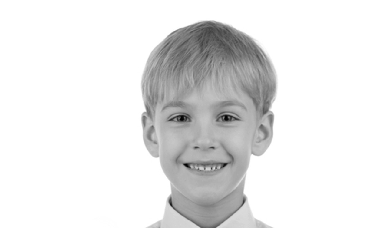

In [32]:
# Code Cell 20
plt.imshow(gray_smile[:, :], cmap='gray')
plt.axis('off')
print('The person in this picture is', answers[pred[0]])

e) Repeat everything with the other test image.

The person in this picture is NOT SMILING.


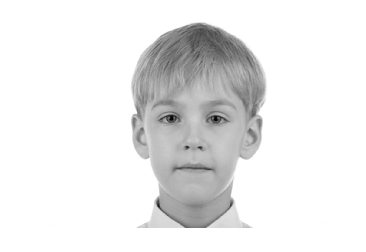

In [34]:
# Code Cell 21
pred = classifier.predict((standardized_face_nosmile.ravel()).reshape(1, -1))

plt.imshow(gray_nosmile[:, :], cmap='gray')
plt.axis('off')
# Print a message with the result of the smile detection
print('The person in this picture is', answers[pred[0]])


## Part 4: Real Time Smile Detection

The final goal of this lab is to take a selfie of smiling people. In this part, you will set up the Picamera, take pictures of smiling people, and save the frame to the folder `selfies`.

### Step 1: Set Up

a) Import the Python script, `smile_utils`.

The Python script [smile_utils.py](smile_utils.py) implements all the actions of the previous steps (face detection, face standardization and smile detection) in functions that can be called in an online loop. 

In [35]:
# Code Cell 22
import smile_utils as su


b) Initilize the cropping coefficients.

In [37]:
# Code Cell 23
# remember the cropping coefficients? Here is an initialization for them.
c1 = 0.1
c2 = 0.1

c) Import the library for use with the Pi camera.

In [38]:
# Code Cell 24
# Setting up the camera
from picamera import PiCamera
from picamera.array import PiRGBArray
from IPython.display import display, clear_output
import time

d) Define the function, `showFrame`, to display the video output.

In [39]:
# Code Cell 25
def showFrame(frame):
    plt.axis('off')
    plt.title('Video Output')
    plt.imshow(frame)
    plt.show()
    clear_output(wait=True)

### Step 3: Online smile detection

a) Verify camera connection and smile detection.

The following piece of code puts together everything shown in this lab, from camera connection to smile detection, in order for it to work in real time.

Wait about 1 min. Click the Stop button to release the video.

In [43]:
# Code Cell 26
try:
    camera.close()
except:
    pass

# initialize the camera and acquire a reference to the raw camera capture
camera = PiCamera()
# Use these two lines to reorient your image if necessary.
#camera.vflip = True
#camera.hflip = True
camera.resolution = (640, 480)
camera.framerate = 3
# allow the camera to warmup
time.sleep(1)
try:
    # looping to get a video from the camera
    while True:
        rawCapture = PiRGBArray(camera)

        # acquire an image from the camera
        camera.capture(rawCapture, format="rgb")
        frame = rawCapture.array
        # creates a copy of the frame to be able to draw on top of it
        new_frame = frame.copy()

        # detect faces
        gray, faces = su.find_face(frame)
    
        # keeps track of how many faces are detected inside a frame
        face_index = 0
        
        # loop over all the detected faces
        for face in faces:
            
            # get the coordinates/size of the current face
            (x, y, w, h) = face

            if w > 100:
            
                # standardize the face
                standardized_face = su.standardize(gray, face, (c1, c2)) #(0.075, 0.05)

                # classify the face
                result = su.is_smiling(standardized_face, classifier)

                # draw extracted face in the top right corner - to have an idea 
                # of what the model is trying to predict
                new_frame[face_index * 64: (face_index + 1) * 64, :64, :] = cv2.cvtColor(standardized_face*255, cv2.COLOR_GRAY2BGR)


                # depending on the result of the classification, pick red or green as a color
                if result == 1:
                    color = (0, 255, 0)
                else:
                    color = (255, 0, 0)

                # increment counter
                face_index += 1
                # draw rectangle around face - green if smiling, red if not smiling
                cv2.rectangle(new_frame, (x, y), (x+w, y+h), color, 2)   

        # Display the new frame
        showFrame(new_frame)
       
    
except KeyboardInterrupt:
    # Click Stop (Black square in the menu) to release the video resource
    
    # Message to be displayed after releasing the device
    print("Released Video Resource")
    camera.close()
    showFrame(frame)

PiCameraValueError: Incorrect buffer length for resolution 640x480

b) After you have verified that the Pi camera module and the smile detector are functioning, you can take a selfie of the smiling people.

If a person smiles for more than a given number of frames, the following piece of code saves the frame to the folder `selfies`. 

Released Video Resource


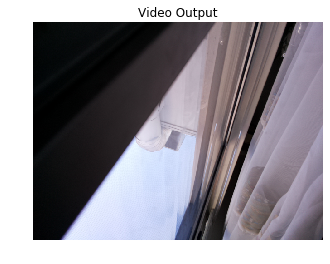

In [42]:
# Code Cell 27
try:
    camera.close()
except:
    pass

# initialize the camera and acquire a reference to the raw camera capture
camera = PiCamera()
# Use these two lines to reorient your image if necessary
#camera.vflip = True
#camera.hflip = True
camera.resolution = (640, 480)
camera.framerate = 3
# allow the camera to warmup
time.sleep(1)
k=0
num_selfie=0
try:
    # looping to get a video from the camera
    while True:
        rawCapture = PiRGBArray(camera)

        # grab an image from the camera
        camera.capture(rawCapture, format="rgb")
        frame = rawCapture.array
        # creates a copy of the frame in order to be able to draw on top of it
        new_frame = frame.copy()

        # detect faces
        gray, faces = su.find_face(frame)
    
        # keeps track of how many faces are detected inside a frame
        face_index = 0
        
        # loop over all the detected faces
        for face in faces:
        
            (x, y, w, h) = face
            if w > 100:
            
                # standardize the face
                standardized_face = su.standardize(gray, face, (c1, c2)) #(0.075, 0.05)

                # classify the face
                result = su.is_smiling(standardized_face, classifier)
                
                # depending on the result of the classification, pick red or green as a color
                # also keeps track of the number of frames a person has been smiling
                if result == 1:
                    k+=1
                    color = (0, 255, 0)
                else:
                    k=0
                    color = (0, 0, 255)
                # if a person has been smiling for more than 1 frames, take a selfie
                if k > 1:
                    plt.imsave('selfies/my_selfie_{}.png'.format(num_selfie), frame)
                    num_selfie+=1
                    new_frame = new_frame * 255
                    k=0
                # draw a rectangle on top of the face
                cv2.rectangle(new_frame, (x, y), (x+w, y+h), color, 2)   

                # increment counter
                face_index += 1
                # draw rectangle around face 

        # Display the resulting frame
        showFrame(new_frame)

except:
    # Message to be displayed after releasing the device
    print("Released Video Resource")
    camera.close()
    showFrame(frame)
    
# Click Stop (Black square in the menu) to release the video resource after the image has been taken.

c) Navigate to the [selfies](selfies) folder to view your selfies.

<font size='0.5'>&copy; 2017 Cisco and/or its affiliates. All rights reserved. This document is Cisco Public. Updated by L.Samuelson 2021.<font>